# Multisite Sublimation in East River
### Daniel Hogan
### University of Washington
--------------------------
This notebook will walk through downloading SAIL and SPLASH data and compare sublimation estimates over a defined period for:
- SAIL ECOR at Gothic
- SAIL ECOR at Kettle Ponds
- SPLASH ASFS at Kettle Ponds
- SPLASH ASFS at Avery Picnic
- Penman-Monteith at Gothic using SAIL MET data
- Bulk Aerodynamic at Gothic using SAIL SEBS and surface temperature

In [2]:
# Import packages

# General imports
import os
import pandas as pd
import numpy as np
import xarray as xr
import datetime as dt

# Toolkits
import nctoolkit as nc
nc.deep_clean() # Ensure nothing is saved to tmp
import metpy.calc as calc

# Statistical Tools
import statsmodels.api as sm
import scipy.stats as stats

# Other Specific packages
import soslib.funcs as sos
import turbpy # need to install my forked version
import turbpy.multiConst as mc
import pyet

# Visualization
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns

Please install CDO version 1.9.3 or above: https://code.mpimet.mpg.de/projects/cdo/ or https://anaconda.org/conda-forge/cdo
Please install CDO version 1.9.3 or above: https://code.mpimet.mpg.de/projects/cdo/ or https://anaconda.org/conda-forge/cdo


In [3]:
# For use when connected to the linuxbox
inpath = '/storage/dlhogan/sos/data'
outpath = '/storage/dlhogan/sos/data/ncdfs'

# Plot formatting
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the 


### Gather data from SAIL and SPLASH

In [4]:
# Product dictionary for ASFS data grabber
product_dict = {'kettle_ponds': {'code':'asfs30', '10_min_avg':'10min', '30_min_avg':'30min'},
                'avery_picnic': {'code':'asfs50', '10_min_avg':'10min', '30_min_avg':'30min'}
                }
fn_dict = ['instrument', 'product_lvl', 'location', 'date', 'time','avg_time', 'file_type']

In [5]:
username = os.getenv("ARM_USERNAME")
token = os.getenv("ARM_TOKEN")
met = 'gucmetM1.b1'
sebs = 'gucsebsM1.b1'
gndirt = 'gucgndirtM1.b1'
ecor_gts = 'guc30ecorM1.b1'
ecor_kp = 'guc30ecorS3.b1'
sdate = '2022-01-01'
edate = '2022-04-30'


# Uses this path if connected to linuxbox
if os.path.isdir(outpath):
    # Grab surface temperature data
    surf_temp_ds = xr.open_dataset(os.path.join(outpath,'surf_temp_ds.nc')).sel(time=slice(sdate,edate))
    # Grab surface energy balance data
    sebs_ds = xr.open_dataset(os.path.join(outpath,'sebs_gts_ds.nc')).sel(time=slice(sdate,edate))
    # Grab meteorological data
    met_ds = xr.open_dataset(os.path.join(outpath,'met_ds.nc')).sel(time=slice(sdate,edate))

    # Pull in ASFS data from SPLASH
    print('Pulling Kettle Ponds ASFS data...')
    kp_asfs_ds = sos.get_asfs_data(product = product_dict['kettle_ponds']['code'], 
                product_lvl=0,
                avg_time=30,
                start=sdate,
                end=edate)

    print('Pulling Avery Picnic ASFS data...')
    ap_asfs_ds = sos.get_asfs_data(product = product_dict['avery_picnic']['code'], 
                product_lvl=0,
                avg_time=30,
                start=sdate,
                end=edate)
    print('Pulling Gothic ECOR data...')
    ecor_gts_ds = sos.get_sail_data(username, token, ecor_gts,
                                sdate, edate);

    print('Pulling Kettle Ponds ECOR data...')
    ecor_kp_ds = sos.get_sail_data(username, token, ecor_gts,
                                sdate, edate);

else: 
    print('You need to pull data!') 

    print('Pulling Kettle Ponds ASFS data...')
    kp_asfs_ds = sos.get_asfs_data(product = product_dict['kettle_ponds']['code'], 
                product_lvl=1,
                avg_time=30,
                start=sdate,
                end=edate);

    print('Pulling Avery Picnic ASFS data...')
    ap_asfs_ds = sos.get_asfs_data(product = product_dict['avery_picnic']['code'], 
                product_lvl=1,
                avg_time=30,
                start=sdate,
                end=edate);
    
    print('Pulling Gothic ECOR data...')
    ecor_gts_ds = sos.get_sail_data(username, token, ecor_gts,
                                sdate, edate);

    print('Pulling Kettle Ponds ECOR data...')
    ecor_kp_ds = sos.get_sail_data(username, token, ecor_kp,
                                sdate, edate);

    print('Pulling surface temp data...') 
    if os.path.exists('surf_temp_ds.nc'):
            surf_temp_ds = xr.open_dataset('surf_temp_ds.nc').sel(time=slice(sdate,edate))
    else:
        surf_temp_ds = sos.get_sail_data(username,token,gndirt,sdate,edate);
    
    print('Pulling surface energy balance data...')
    if os.path.exists('sebs_ds.nc'):
        sebs_ds = xr.open_dataset('sebs_ds.nc').sel(time=slice(sdate,edate))
    else:   
        sebs_ds = sos.get_sail_data(username,token,sebs,sdate,edate);

    print('Pulling met data...')
    if os.path.exists('met_ds.nc'):
        met_ds = xr.open_dataset('met_ds.nc').sel(time=slice(sdate,edate))
    else:
        met_ds = sos.get_sail_data(username,token,met,sdate,edate);
    print('Done!')

    print('Pulling radsys data...')
    radsys_ds = sos.get_daily_radsys_data(sdate,edate)
    radsys_ds.Baro.attrs['units'] = 'hPa'
    radsys_ds.AirTemp.attrs['units'] = 'celsius'
    print('Done!')
    

You need to pull data!
Pulling Kettle Ponds ASFS data...
Connecting to FTP Server...
Got 119 files!
                             
Loading turbsled.level1.asfs30-pond.20220101.000000.30min.nc...
Dropping freq dimension due to concatenation issues.
                             
Loading turbsled.level1.asfs30-pond.20220102.000000.30min.nc...
Dropping freq dimension due to concatenation issues.
                             
Loading turbsled.level1.asfs30-pond.20220103.000000.30min.nc...
Dropping freq dimension due to concatenation issues.
                             
Loading turbsled.level1.asfs30-pond.20220104.000000.30min.nc...
Dropping freq dimension due to concatenation issues.
                             
Loading turbsled.level1.asfs30-pond.20220105.000000.30min.nc...
Dropping freq dimension due to concatenation issues.
                             
Loading turbsled.level1.asfs30-pond.20220106.000000.30min.nc...
Dropping freq dimension due to concatenation issues.
                  

### Compute daily sublimation rates for different instruments

In [6]:
# Latent heat of sublimation and seconds per day
lv_sublimation = 2.837e6 # J/kg
sec_per_day = 24*3600

# Compute sublimation rate using bulk values from ASFS and ECOR latent heat values
sublimation_rate_kp = kp_asfs_ds['bulk_Hl_Webb']/ecor_gts_ds.lv * sec_per_day # mm/10-mins
sublimation_rate_ap = ap_asfs_ds['bulk_Hl_Webb']/ecor_gts_ds.lv  * sec_per_day # mm/10-mins
sublimation_rate_gts = ecor_gts_ds.where(ecor_gts_ds.qc_lv_e == 0).lv_e/ecor_gts_ds.where(ecor_gts_ds.qc_lv_e == 0).lv * sec_per_day # mm/10-mins
sublimation_rate_ecor_kp = ecor_kp_ds.where(ecor_kp_ds.qc_lv_e == 0).lv_e/ecor_kp_ds.where(ecor_kp_ds.qc_lv_e == 0).lv * sec_per_day # mm/10-mins

# Convert to dataframes
df_kp = sublimation_rate_kp.resample(time='1D').mean().to_pandas()
df_avery = sublimation_rate_ap.resample(time='1D').mean().to_pandas()
df_gts = sublimation_rate_gts.resample(time='1D').mean().to_pandas()
df_ecor_kp = sublimation_rate_ecor_kp.resample(time='1D').mean().to_pandas()

### Calucluate daily PET estimate using Penman-Monteith

In [8]:
# Min, max and mean  temperature in Gothic
temp_max = met_ds.temp_mean.resample(time='1D').max().to_pandas()
temp_min = met_ds.temp_mean.resample(time='1D').min().to_pandas()
temp_mean = met_ds.temp_mean.resample(time='1D').mean().to_pandas()
# Min, max and mean  RH in Gothic
rh_mean = met_ds.rh_mean.resample(time='1D').mean().to_pandas()
rh_max = met_ds.rh_mean.resample(time='1D').max().to_pandas()
rh_min = met_ds.rh_mean.resample(time='1D').min().to_pandas()
#  average wind speed in Gothic
wind_mean = met_ds.wspd_arith_mean.resample(time='1D').mean().to_pandas()
# Average pressure in Gothic (hPa)
press_mean = met_ds.atmos_pressure.resample(time='1D').mean().to_pandas()*10
# Net radiation and net solar radiation
rn = sebs_ds.net_radiation.resample(time='1D').mean().to_pandas()*3600*24/1e6
rs = sebs_ds.where(sebs_ds.qc_down_short_hemisp==0).down_short_hemisp.resample(time='1D').mean().to_pandas()*3600*24/1e6
# Location information
elev = np.unique(met_ds.alt)[0]
lat = np.unique(met_ds.lat)[0] * np.pi/180
lon = np.unique(met_ds.lon)[0] * np.pi/180

# Calculate Penman-Monteith PET
sublimation_pm = pyet.pm(tmean=temp_mean,
        wind=wind_mean,
        rh=rh_mean,
        tmax=temp_max,
        tmin=temp_min, 
        rn=rn,
        lat=lat,
        elevation=elev,
        r_l=0,
        r_s=0,
        ra_method=1)

### Calucluate hourly PET estimate using Penman-Monteith

In [9]:
# Min, max and mean  temperature in Gothic
temp_max = met_ds.temp_mean.resample(time='1H').max().to_pandas()
temp_min = met_ds.temp_mean.resample(time='1H').min().to_pandas()
temp_mean = met_ds.temp_mean.resample(time='1H').mean().to_pandas()
# Min, max and mean  RH in Gothic
rh_mean = met_ds.rh_mean.resample(time='1H').mean().to_pandas()
rh_max = met_ds.rh_mean.resample(time='1H').max().to_pandas()
rh_min = met_ds.rh_mean.resample(time='1H').min().to_pandas()
#  average wind speed in Gothic
wind_mean = met_ds.wspd_arith_mean.resample(time='1H').mean().to_pandas()
# Average pressure in Gothic (hPa)
press_mean = met_ds.atmos_pressure.resample(time='1H').mean().to_pandas()*10
# Net radiation and net solar radiation
rn = sebs_ds.net_radiation.resample(time='1H').mean().to_pandas()*3600*24/1e6
rs = sebs_ds.where(sebs_ds.qc_down_short_hemisp==0).down_short_hemisp.resample(time='1H').mean().to_pandas()*3600*24/1e6

# Calculate hourly PM PET
sublimation_pm_hourly = pyet.pm(tmean=temp_mean,
        wind=wind_mean,
        rh=rh_mean,
        rhmin=rh_min,
        rhmax=rh_max,
        tmax=temp_max,
        tmin=temp_min, 
        rn=rn,
        rs=rs,
        elevation=elev)

### Find days when instruments have data available or when it is NaN

In [83]:
# measurements with 30 minute averaging time
measurements_per_day=48
# Fraction for a valid day of data
valid_fraction=0.5
# Valid data when True
# Compute for ASFS sublimation at KP
df_kp = sublimation_rate_kp.to_pandas().resample('1D').agg(['mean','count'])
invalid_asfs_kp = df_kp['count'] <= measurements_per_day*valid_fraction
df_kp = df_kp['mean']
df_kp[invalid_asfs_kp] = np.nan
df_kp.name='ASFS_KP'

# Compute for ASFS sublimation at AP
df_avery = sublimation_rate_ap.to_pandas().resample('1D').agg(['mean','count'])
invalid_asfs_ap = df_avery['count'] <=measurements_per_day*valid_fraction
df_avery = df_avery['mean']
df_avery[invalid_asfs_ap] = np.nan
df_avery.name='ASFS_AP'

# Compute for SAIL sublimation at Gothic
df_gts = sublimation_rate_gts.to_pandas().resample('1D').agg(['mean','count'])
invalid_gts = df_gts['count'] <=measurements_per_day*valid_fraction
df_gts = df_gts['mean']
df_gts[invalid_gts] = np.nan
df_gts.name='SAIL_Gothic'

# Compute for SAIL sublimation at KP
df_ecor_kp = sublimation_rate_ecor_kp.to_pandas().resample('1D').agg(['mean','count'])
invalid_ecor_kp = df_ecor_kp['count'] <=measurements_per_day*valid_fraction
df_ecor_kp = df_ecor_kp['mean']
df_ecor_kp[invalid_ecor_kp] = np.nan
df_ecor_kp.name='SAIL_KP'

In [87]:
sub_date_idx = pd.concat([df_kp,df_avery,df_gts,df_ecor_kp], axis=1).dropna().index
sub_date_idx = sub_date_idx[1:-4] # skip days so its a continuous series
sub_date_idx

DatetimeIndex(['2022-03-08', '2022-03-10', '2022-03-11', '2022-03-12',
               '2022-03-13', '2022-03-15', '2022-03-16', '2022-03-18',
               '2022-03-19', '2022-03-20', '2022-03-21', '2022-03-22',
               '2022-03-23', '2022-03-24', '2022-03-25', '2022-03-26',
               '2022-03-27', '2022-03-28', '2022-03-31', '2022-04-02',
               '2022-04-06', '2022-04-13', '2022-04-14'],
              dtype='datetime64[ns]', name='time', freq=None)

### Estimate sublimation using bulk aerodynamic method with turbpy 

#### Using SAIL data in Gothic

In [88]:
# Mean 30 minute surface temperature
surface_temp_1min = surf_temp_ds.where(surf_temp_ds.qc_sfc_ir_temp==0).sfc_ir_temp.resample(time='30min').mean()
surface_temp_1min.attrs = {'units':'K'}
# Mean 30 minute air temperature
airTemp_1min = met_ds.where(met_ds.qc_temp_mean==0).temp_mean.resample(time='30min').mean()+273.15
# Mean 30 minute wind speed
wspd_1min = met_ds.wspd_arith_mean.resample(time='30min').mean()
# Measurement heights and constasts/assumptions
mHeightT = 2. 
wHeightU = 10.
z0Ground = .00031
snowDepth = 1.
scalarGroundSnowFraction  = 1.
# Vapor pressure of air
airVaporPress = met_ds.vapor_pressure_mean.resample(time='30min').mean()*1000
# Vapor pressure at surface assuming saturation
sfcVaporPress = calc.saturation_vapor_pressure(surface_temp_1min)
# air pressure mean
airPressure = met_ds.atmos_pressure.resample(time='30min').mean()*1000

In [89]:
# Compute bulk aerodynamic latent heat
bulk_Hl = []
for i in range(len(airTemp_1min.dropna(dim='time').values)):
    bulk_Hl.append(turbpy.turbFluxes(      airTemp=airTemp_1min.dropna(dim='time').values[i],
                        airPres=airPressure.dropna(dim='time').values[i],
                        airVaporPress=airVaporPress.dropna(dim='time').values[i],
                        windspd=wspd_1min.dropna(dim='time').values[i],
                        sfcTemp=surface_temp_1min.dropna(dim='time').values[i],
                        sfcVaporPress=sfcVaporPress.dropna(dim='time').values[i],
                        snowDepth=snowDepth,
                        mHeight=10,
                        groundSnowFraction=scalarGroundSnowFraction,
                        param_dict={'MO (Cheng/Brutsaert)': 'monin_obukhov'},
                        z0Ground=z0Ground,)[3])

# Latent heat using bulk aero method
Hl_bulk_gothic = pd.Series(bulk_Hl,index=airTemp_1min.dropna(dim='time').time)
# Convert to sublimation
sublimation_bulk_gts = -Hl_bulk_gothic.resample('1D').mean()/lv_sublimation * sec_per_day

#### Using SPLASH data at KP

In [90]:
# Compute surface temperature from IR
sigma = 5.67e-8
emissivity = 0.97
surf_temp_lw = ((radsys_ds.where(radsys_ds.uw_ir_qc==0).uw_ir/(sigma*emissivity))**(0.25)).resample(time='30min').mean()
surf_temp_lw.attrs = {'units':'K'}

# Get air temperature and windspeed
airTemp = radsys_ds.where(radsys_ds.AirTemp_qc==0).AirTemp.resample(time='30min').mean()+273.15
wspd = radsys_ds.where(radsys_ds.WindSpd_qc==0).WindSpd.resample(time='30min').mean()
mHeightT = 2. 
wHeightU = 2.
z0Ground = .00031 #0.005
snowDepth = 1.
scalarGroundSnowFraction  = 1.
# Compute vapor pressure from air temperature
w = calc.mixing_ratio_from_relative_humidity(radsys_ds.Baro,radsys_ds.AirTemp, radsys_ds.RH)
e = calc.vapor_pressure(radsys_ds.Baro, w)*100
e.attrs['Units'] = 'pascal'

# Compute saturation vapor pressure at surface temperature
sfcVaporPress = calc.saturation_vapor_pressure(surf_temp_lw)

# Grab air pressure
airPressure = radsys_ds.where(radsys_ds.Baro_qc==0).Baro.resample(time='30min').mean()*1000

bulk_Hl = []
for i in range(len(airTemp.dropna(dim='time').values)):
    bulk_Hl.append(turbpy.turbFluxes(      airTemp=airTemp.dropna(dim='time').values[i],
                        airPres=airPressure.dropna(dim='time').values[i],
                        airVaporPress=e.dropna(dim='time').values[i],
                        windspd=wspd.dropna(dim='time').values[i],
                        sfcTemp=surf_temp_lw.dropna(dim='time').values[i],
                        sfcVaporPress=sfcVaporPress.dropna(dim='time').values[i],
                        snowDepth=snowDepth,
                        mHeight=mHeightT,
                        groundSnowFraction=scalarGroundSnowFraction,
                        param_dict={'MO (Cheng/Brutsaert)': 'monin_obukhov'},
                        z0Ground=z0Ground,)[3])

Hl_bulk_kp = pd.Series(bulk_Hl,index=airTemp.dropna(dim='time').time)
lv = 2.834e6
sublimation_bulk_kp = -Hl_bulk_kp.resample('1D').mean()/lv_sublimation * sec_per_day

### Grab weather codes from met data in Gothic

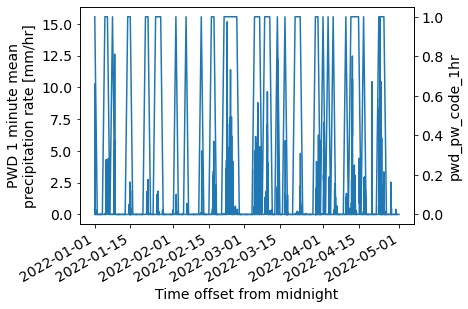

In [91]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
# when weather code exceeds 20% of the day, classify as storm rolling through
weather_code = met_ds.where(met_ds.qc_pwd_pw_code_1hr==0).pwd_pw_code_1hr > 66
weather_code_daily = (weather_code.resample(time='1D').mean() > 0.2) 

met_ds.where(met_ds.qc_pwd_precip_rate_mean_1min==0).pwd_precip_rate_mean_1min.plot(ax=ax)
weather_code_daily.plot(ax=ax2)

### Time-series plot of daily sublimation

Text(0.5, 0.9, 'Sublimation/Deposition Across East River Jan 1 - May 1  2022')

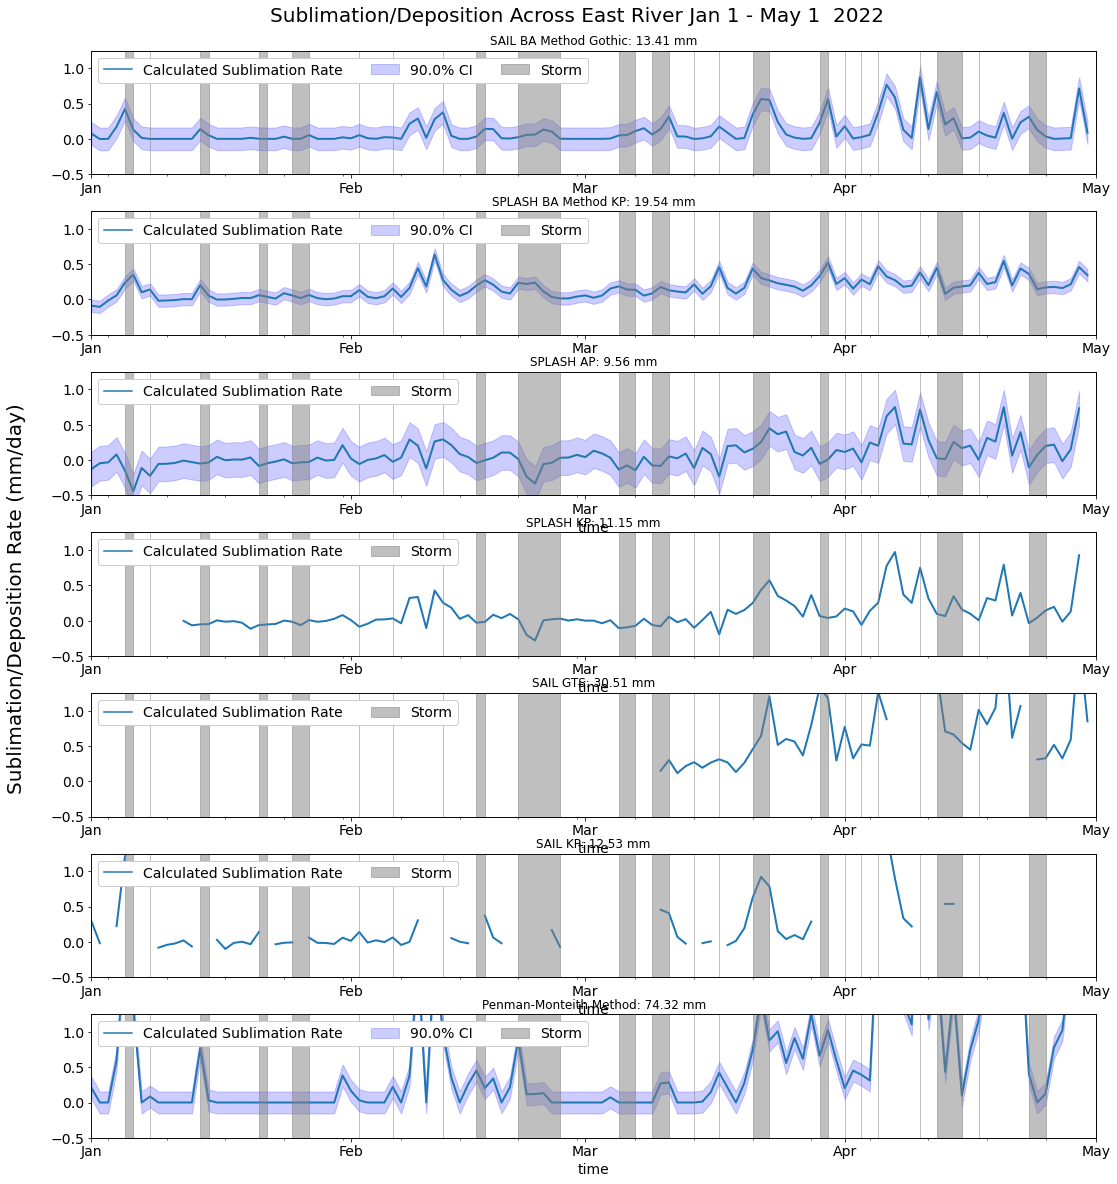

In [92]:
# Function to add confidence intervals
def confidence_interval(sublimation_ds, bounds=0.05):
    ci = bounds * np.std(sublimation_ds.values) / np.mean(sublimation_ds.values)
    return ci

# Creat plot
fig, axs = plt.subplots(nrows=7,figsize=(18,20),sharex=False, sharey=True)
fig.subplots_adjust(hspace=0.3)

axs = axs.ravel()
# Create labels
labels = [f'SAIL BA Method Gothic: {round(sublimation_bulk_gts.sum(),2)} mm',
          f'SPLASH BA Method KP: {round(sublimation_bulk_kp.sum(),2)} mm',
          f'SPLASH AP: {round(df_avery.sum(),2)} mm',
          f'SPLASH KP: {round(df_kp.sum(),2)} mm',
          f'SAIL GTS: {round(df_gts.sum(),2)} mm',
          f'SAIL KP: {round(df_ecor_kp.sum(),2)} mm',
          f'Penman-Monteith Method: {round(sublimation_pm.sum(),2)} mm',
          ]

bounds = 0.1

# Plot for SAIL bulk aerodynamic sublimation in Gothic
sublimation_bulk_gts.plot(ax=axs[0], lw=2, label='Sublimation Rate Estimate')
ci = confidence_interval(sublimation_bulk_gts, bounds=bounds)
axs[0].fill_between(sublimation_bulk_gts.index, (sublimation_bulk_gts-ci), (sublimation_bulk_gts+ci),color='blue', alpha=0.2, label=f'{100*(1-bounds)}% CI')
# Plot for SPLASH bulk aerodynamic sublimation at KP
sublimation_bulk_kp.plot(ax=axs[1], lw=2, label='Sublimation Rate Estimate')
ci = confidence_interval(sublimation_bulk_kp, bounds=bounds)
axs[1].fill_between(sublimation_bulk_kp.index, (sublimation_bulk_kp-ci), (sublimation_bulk_kp+ci),color='blue', alpha=0.2, label=f'{100*(1-bounds)}% CI')
# Plot for SPLASH ASFS sublimation at AP
df_avery.plot(ax=axs[2], lw=2, label='Sublimation Rate Estimate')
ci = confidence_interval(df_avery, bounds=bounds)
axs[2].fill_between(df_avery.index, (df_avery-ci), (df_avery+ci),color='blue', alpha=0.2, label=f'{100*(1-bounds)}% CI')
# Plot for SPLASH ASFS sublimation at KP
df_kp.plot(ax=axs[3], lw=2, label='Sublimation Rate Estimate')
ci = confidence_interval(df_kp, bounds=bounds)
axs[3].fill_between(df_kp.index, (df_kp-ci), (df_kp+ci),color='blue', alpha=0.2, label=f'{100*(1-bounds)}% CI')
# Plot for SAIL ECOR sublimation at Gothic
df_gts.plot(ax=axs[4], lw=2, label='Sublimation Rate Estimate')
ci = confidence_interval(df_gts, bounds=bounds)
axs[4].fill_between(df_gts.index, (df_gts-ci), (df_gts+ci),color='blue', alpha=0.2, label=f'{100*(1-bounds)}% CI')
# Plot for SAIL ECOR sublimation at KP
df_ecor_kp.plot(ax=axs[5], lw=2, label='Sublimation Rate Estimate')
ci = confidence_interval(df_ecor_kp, bounds=bounds)
axs[5].fill_between(df_ecor_kp.index, (df_ecor_kp-ci), (df_ecor_kp+ci),color='blue', alpha=0.2, label=f'{100*(1-bounds)}% CI')
# Plot for PM PET at Gothic
sublimation_pm.plot( ax=axs[6], lw=2, label='Sublimation Rate Estimate')
ci = confidence_interval(sublimation_pm, bounds=bounds)
axs[6].fill_between(sublimation_pm.index, (sublimation_pm-ci), (sublimation_pm+ci),color='blue', alpha=0.2, label=f'{100*(1-bounds)}% CI')

# Use for formatting each axes
for i,ax in enumerate(axs):
    ax2 = ax.twinx()
    if i in [0,1,6]:
        ax2.fill_between(weather_code_daily.time,10,20, color='blue', where=weather_code_daily == True, alpha=0.2, label=f'{100*(1-bounds)}% CI')
    ax2.plot([],[], label='Calculated Sublimation Rate')

    ax2.fill_between(weather_code_daily.time,0,1, color='grey', where=weather_code_daily == True, alpha=0.5, label='Storm')
    
    ax2.get_yaxis().set_ticks([])
    # ax.set_xticklabels(ax.get_xticks(), rotation = 45)
    ax2.legend(ncol=3, loc='upper left', framealpha=1)
    ax.set_xticks([dt.date(2022,1,1),dt.date(2022,2,1),dt.date(2022,3,1),dt.date(2022,4,1),dt.date(2022,5,1)])
    ax2.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May'])
    ax.set_title(labels[i], fontsize=12)
    ax.set_ylim(-0.5,1.25)
    ax2.set_ylim(0,1)

# Figure titles
fig.text(0.06,0.5, 'Sublimation/Deposition Rate (mm/day)', va='center', rotation='vertical', fontsize=20)
fig.text(0.5,0.9,'Sublimation/Deposition Across East River Jan 1 - May 1  2022', ha='center',fontsize=20)


### Plot diurnal sublimation estimates

In [139]:
# Create diurnal averages for all the data and index to solid period of data
idx = pd.to_datetime(sublimation_rate_kp.time.dt.date).isin(sub_date_idx)
diurnal_kp = sublimation_rate_kp.loc[idx].groupby('time.hour').mean()/24

idx = pd.to_datetime(sublimation_rate_ap.time.dt.date).isin(sub_date_idx)
diurnal_avery = sublimation_rate_ap.loc[idx].groupby('time.hour').mean()/24

idx = pd.to_datetime(sublimation_rate_gts.time.dt.date).isin(sub_date_idx)
diurnal_gts = sublimation_rate_gts.loc[idx].groupby('time.hour').mean()/24

idx = pd.to_datetime(sublimation_rate_ecor_kp.time.dt.date).isin(sub_date_idx)
diurnal_ecor_kp = sublimation_rate_ecor_kp.loc[idx].groupby('time.hour').mean()/24

idx = pd.to_datetime(Hl_bulk_gothic.index.date).isin(sub_date_idx)
diurnal_sublimation_bulk_gts = -Hl_bulk_gothic.loc[idx].groupby(Hl_bulk_gothic.loc[idx].index.hour).mean()/lv * 3600

idx = pd.to_datetime(Hl_bulk_kp.index.date).isin(sub_date_idx)
diurnal_sublimation_bulk_kp = -Hl_bulk_kp.loc[idx].groupby(Hl_bulk_kp.loc[idx].index.hour).mean()/lv * 3600

idx = pd.to_datetime(sublimation_pm_hourly.index.date).isin(sub_date_idx)
diurnal_sublimation_pm = sublimation_pm_hourly.loc[idx].groupby(sublimation_pm_hourly.loc[idx].index.hour).mean()/24

### Plot different methods for March 10 to March 31, 2022

Text(0.5, 1.0, 'Mean Daily Sublimation Rate Profile\nMarch 8 to March 31, 2022')

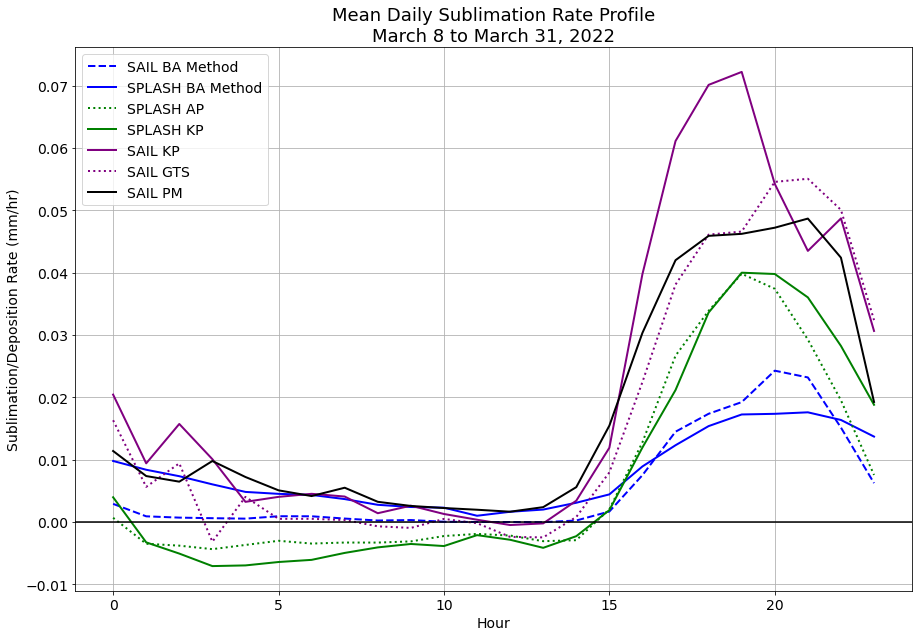

In [140]:
fig, ax = plt.subplots(figsize=(15,10))
diurnal_sublimation_bulk_gts.plot(label='SAIL BA Method', ax=ax, ls='dashed', lw=2, color='blue')
diurnal_sublimation_bulk_kp.plot(label='SPLASH BA Method', ax=ax, lw=2, color='blue')

diurnal_avery.plot(label='SPLASH AP', ax=ax, color='green', ls='dotted', lw=2)
diurnal_kp.plot(label='SPLASH KP', ax=ax, color='green', lw=2)

diurnal_ecor_kp.plot(label='SAIL KP', ax=ax, color='purple', lw=2)
diurnal_gts.plot(label='SAIL GTS', ax=ax, color='purple', ls='dotted', lw=2)

(diurnal_sublimation_pm).plot(label='SAIL PM', ax=ax, color='black', lw=2)

ax.axhline(0, color='black')
ax.grid()

ax.legend()
ax.set_xlabel('Hour')
ax.set_ylabel('Sublimation/Deposition Rate (mm/hr)')
ax.set_title('Mean Daily Sublimation Rate Profile\nMarch 10 to March 31, 2022',size=18)

In [ ]:
# Create diurnal averages for all the data

diurnal_kp = sublimation_rate_kp.groupby('time.hour').mean()/24
diurnal_avery = sublimation_rate_ap.groupby('time.hour').mean()/24
diurnal_gts = sublimation_rate_gts.groupby('time.hour').mean()/24
diurnal_ecor_kp = sublimation_rate_ecor_kp.groupby('time.hour').mean()/24
diurnal_sublimation_bulk_gts = -Hl_bulk_gothic.groupby(Hl_bulk_gothic.index.hour).mean()/lv * 3600
diurnal_sublimation_bulk_kp = -Hl_bulk_kp.groupby(Hl_bulk_kp.index.hour).mean()/lv * 3600
diurnal_sublimation_pm = sublimation_pm_hourly.groupby(sublimation_pm_hourly.index.hour).mean()/24

Text(0.5, 1.0, 'Mean Daily Sublimation Rate Profile\nMarch 10 to April 13, 2022')

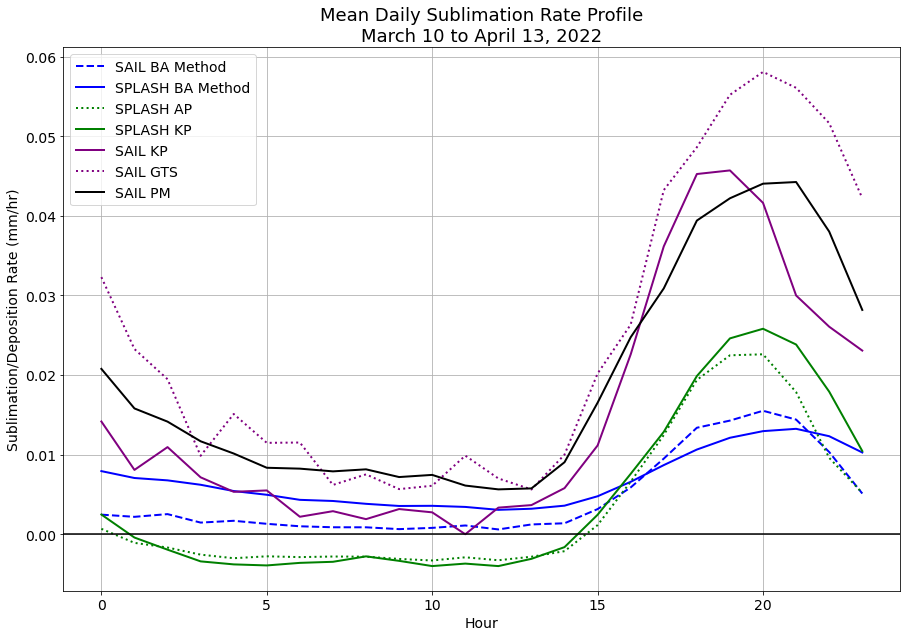

In [133]:
fig, ax = plt.subplots(figsize=(15,10))
diurnal_sublimation_bulk_gts.plot(label='SAIL BA Method', ax=ax, ls='dashed', lw=2, color='blue')
diurnal_sublimation_bulk_kp.plot(label='SPLASH BA Method', ax=ax, lw=2, color='blue')

diurnal_avery.plot(label='SPLASH AP', ax=ax, color='green', ls='dotted', lw=2)
diurnal_kp.plot(label='SPLASH KP', ax=ax, color='green', lw=2)

diurnal_ecor_kp.plot(label='SAIL KP', ax=ax, color='purple', lw=2)
diurnal_gts.plot(label='SAIL GTS', ax=ax, color='purple', ls='dotted', lw=2)

(diurnal_sublimation_pm).plot(label='SAIL PM', ax=ax, color='black', lw=2)

ax.axhline(0, color='black')
ax.grid()

ax.legend()
ax.set_xlabel('Hour')
ax.set_ylabel('Sublimation/Deposition Rate (mm/hr)')
ax.set_title('Mean Daily Sublimation Rate Profile\nMarch 10 to April 13, 2022',size=18)

### Plot correlogram of sublimation from different instruments

In [22]:
sub_df = pd.DataFrame(index=df_avery.index, columns=['ecor_kp', 'ap', 'kp', 'gts', 'bulk_gts', 'bulk_kp', 'pm'])

sub_df['ecor_kp'] = df_ecor_kp
sub_df['ap'] = df_avery
sub_df['kp'] = df_kp
sub_df['gts'] = df_gts
sub_df['bulk_gts'] = sublimation_bulk_gts
sub_df['bulk_kp'] = sublimation_bulk_kp
sub_df['pm'] = sublimation_pm

g = sns.pairplot(sub_df)
g.fig.suptitle('Sublimation Pairplot', y=1.05)

<AxesSubplot:>

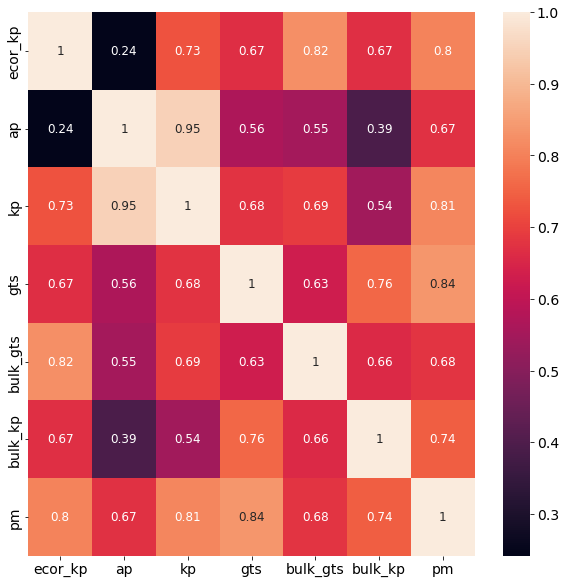

In [57]:
corrMatrix=sub_df.corr()

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corrMatrix, annot=True, ax=ax)



### Dileniate data available during the day and during the night

In [141]:
def day_night_filter(ds, day=True):
    if day:
        tmp = ds.where((ds.time.dt.hour>13) | (ds.time.dt.hour<=1), drop=True)
    else:
        tmp = ds.where((ds.time.dt.hour<=13) & (ds.time.dt.hour>1), drop=True)
    return tmp

In [142]:
print(f'Daytime Invalid Fraction: {day_night_filter(ecor_gts_ds.lv_e).isnull().sum().values/len(day_night_filter(ecor_gts_ds.lv_e, day=True))}')
print(f'Nighttime Invalid Fraction: {day_night_filter(ecor_gts_ds.lv_e, day=False).isnull().sum().values/len(day_night_filter(ecor_gts_ds.lv_e, day=False))}')

Daytime Invalid Fraction: 0.5964484679665738
Nighttime Invalid Fraction: 0.6527777777777778


In [55]:
print(f'Daytime Invalud Fraction: {day_night_filter(ecor_kp_ds.lv_e).isnull().sum().values/len(day_night_filter(ecor_kp_ds.lv_e, day=True))}')
print(f'Nighttime Invalid Fraction: {day_night_filter(ecor_kp_ds.lv_e, day=False).isnull().sum().values/len(day_night_filter(ecor_kp_ds.lv_e, day=False))}')

Daytime Invalud Fraction: 0.6721763085399449
Nighttime Invalid Fraction: 0.3236914600550964


In [56]:
print(f'Daytime Invalid Fraction: {day_night_filter(kp_asfs_ds.bulk_Hl_Webb).isnull().sum().values/len(day_night_filter(kp_asfs_ds.bulk_Hl_Webb, day=True))}')
print(f'Nighttime Invalid Fraction: {day_night_filter(kp_asfs_ds.bulk_Hl_Webb, day=False).isnull().sum().values/len(day_night_filter(kp_asfs_ds.bulk_Hl_Webb, day=False))}')

Daytime Invalid Fraction: 0.09513888888888888
Nighttime Invalid Fraction: 0.09166666666666666


In [57]:
print(f'Daytime Invalid Fraction: {day_night_filter(ap_asfs_ds.bulk_Hl_Webb).isnull().sum().values/len(day_night_filter(ap_asfs_ds.bulk_Hl_Webb, day=True))}')
print(f'Nighttime Invalid Fraction: {day_night_filter(ap_asfs_ds.bulk_Hl_Webb, day=False).isnull().sum().values/len(day_night_filter(ap_asfs_ds.bulk_Hl_Webb, day=False))}')

Daytime Invalid Fraction: 0.008333333333333333
Nighttime Invalid Fraction: 0.008333333333333333


## Check diurnal cycle of sublimation under different conditions

In [143]:
# when weather code exceeds 20% of the day, classify as storm rolling through
weather_code = met_ds.where(met_ds.qc_pwd_pw_code_1hr==0).pwd_pw_code_1hr > 60
weather_code_daily = (weather_code.resample(time='1D').mean() > 0.2) 

In [144]:
%%capture
tsi = 'guctsiskycoverM1.b1'

tsi_ds = sos.get_sail_data(username,token,tsi,sdate,edate)

In [202]:
all_days = ~met_ds.wspd_arith_mean.resample(time='1D').mean().isnull()
windy_days = (met_ds.wspd_arith_mean.resample(time='1D').mean() > np.percentile(met_ds.wspd_arith_mean.resample(time='1D').mean(),75))
sunny_days = (tsi_ds.sunny.resample(time='1D').mean() > 0.75)
dry_days = (met_ds.rh_mean.resample(time='1D').mean() < np.percentile(met_ds.rh_mean.resample(time='1D').mean(),25))
storm_days = weather_code_daily
cold_days = (met_ds.temp_mean.resample(time='1D').mean() < np.percentile(met_ds.temp_mean.resample(time='1D').mean(), 25))
warm_days = (met_ds.temp_mean.resample(time='1D').mean() > np.percentile(met_ds.temp_mean.resample(time='1D').mean(), 75))
stable_days = ~windy_days & sunny_days & ~storm_days

diurnal_cycles = [all_days.loc[sub_date_idx],
                  windy_days.loc[sub_date_idx],
                  sunny_days.loc[sub_date_idx],
                  dry_days.loc[sub_date_idx],
                  storm_days.loc[sub_date_idx], 
                  cold_days.loc[sub_date_idx], 
                  warm_days.loc[sub_date_idx], 
                  stable_days.loc[sub_date_idx]]
labels = [f'All days - {(diurnal_cycles[0].sum())} days', 
          f'Windy days - {(diurnal_cycles[1].sum())} days\n(>75th percentile of mean wind speed)', 
          f'Sunny days - {(diurnal_cycles[2].sum())} days\n(>75% of day)', 
          f'Dry days - {(diurnal_cycles[3].sum())} days\n(<25th percentile of mean relative humidity)', 
          f'Stormy days - {(diurnal_cycles[4].sum())} days\n(snowing for more than 20% of day)',
          f'Cold days - {(diurnal_cycles[5].sum())} days\n(<25th percentile of daily mean temp)',
          f'Warm days - {(diurnal_cycles[6].sum())} days\n(>75th percentile of daily mean temp)',
          f'Stable days - {(diurnal_cycles[7].sum())} days\n(sunny, calm, no snow)']

In [203]:
labels[1]

'Windy days - 6 days\n(>75th percentile of mean wind speed)'

In [174]:
import pytz
def add_local_time(ds):
    time_utc = ds['time'].to_index().tz_localize(pytz.UTC)
    us_mtn = pytz.timezone('US/Mountain')
    tz_corrected = time_utc.tz_convert(us_mtn).tz_localize(None)
    local_da=xr.DataArray.from_series(tz_corrected)
    ds.coords.update({'local_time':tz_corrected})
    return ds

In [216]:
# Make datasets tz aware
sublimation_rate_kp_df = add_local_time(sublimation_rate_kp)
sublimation_rate_kp_df.name='SPLASH KP'
sublimation_rate_kp_df = sublimation_rate_kp_df.to_dataframe().set_index('local_time')

sublimation_rate_ap_df = add_local_time(sublimation_rate_ap)
sublimation_rate_ap_df.name='SPLASH AP'
sublimation_rate_ap_df = sublimation_rate_ap_df.to_dataframe().set_index('local_time')

sublimation_rate_gts_df = add_local_time(sublimation_rate_gts)
sublimation_rate_gts_df.name='SAIL Gothic'
sublimation_rate_gts_df = sublimation_rate_gts_df.to_dataframe().set_index('local_time')

sublimation_rate_ecor_kp_df = add_local_time(sublimation_rate_ecor_kp)
sublimation_rate_ecor_kp_df.name='SAIL KP'
sublimation_rate_ecor_kp_df = sublimation_rate_ecor_kp_df.to_dataframe().set_index('local_time')

In [223]:
# Make dataframes time zone aware
Hl_bulk_gothic.index = Hl_bulk_gothic.index.tz_localize('UTC')
Hl_bulk_gothic.index = Hl_bulk_gothic.index.tz_convert('US/Mountain')

Hl_bulk_kp.index = Hl_bulk_kp.index.tz_localize('UTC')
Hl_bulk_kp.index = Hl_bulk_kp.index.tz_convert('US/Mountain')

sublimation_pm_hourly.index = sublimation_pm_hourly.index.tz_localize('UTC')
sublimation_pm_hourly.index = sublimation_pm_hourly.index.tz_convert('US/Mountain')

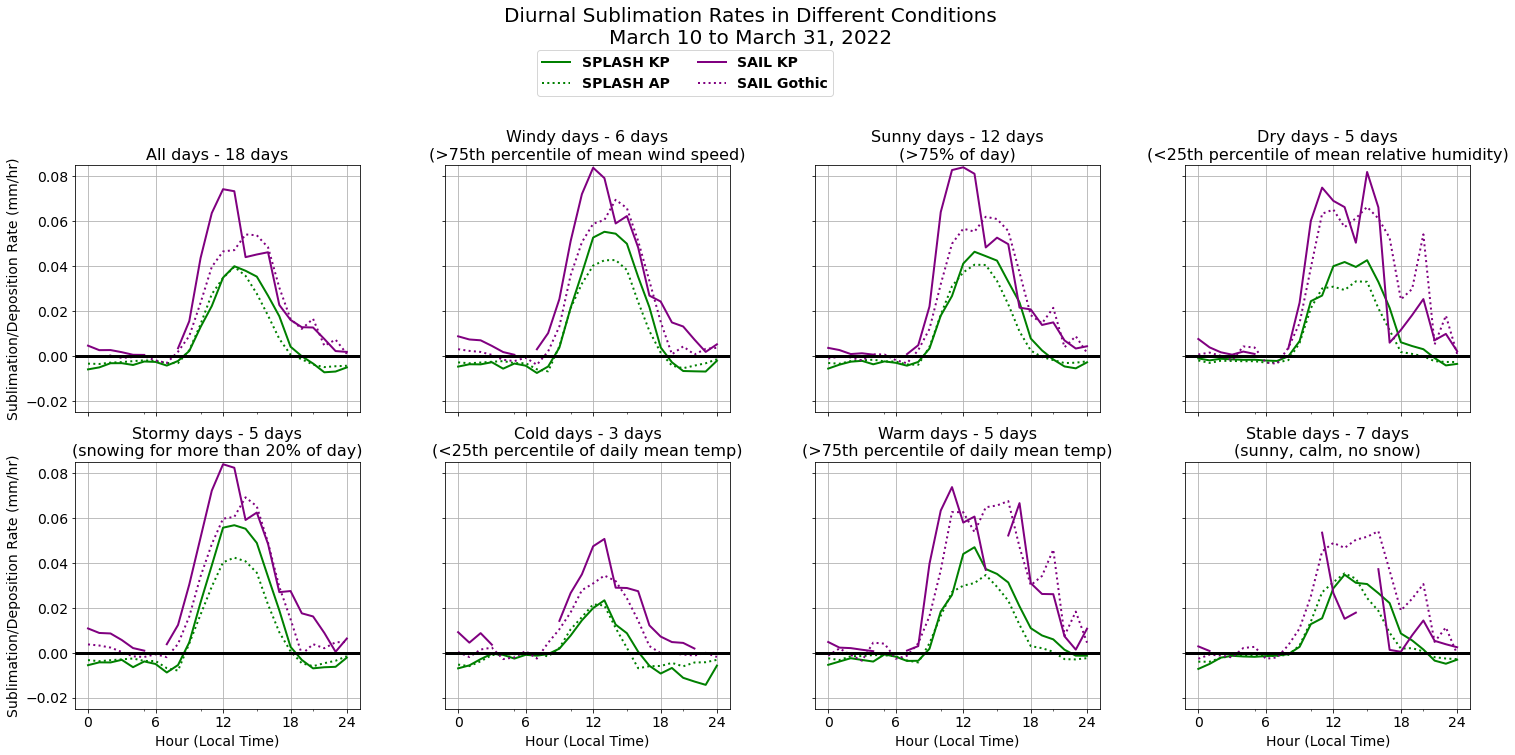

In [229]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(25,10), sharex=True, sharey=True,  facecolor='white')
fig.subplots_adjust(hspace=0.2,wspace=0.3)
axs = axs.ravel()

fig.suptitle('Diurnal Sublimation Rates in Different Conditions\nMarch 10 to March 31, 2022', fontsize=20, y=1.10)

for i,cycle in enumerate(diurnal_cycles):
    days = cycle.where(cycle == True, drop=True).time.dt.date.values

    ec_asfs_kp = sublimation_rate_kp_df[np.isin(sublimation_rate_kp_df.index.date, days)]
    (ec_asfs_kp.groupby(ec_asfs_kp.index.hour).mean()/24).plot(ax=axs[i], label='SPLASH KP', color='green', lw=2, legend=False)

    ec_asfs_ap = sublimation_rate_ap_df[np.isin(sublimation_rate_ap_df.index.date, days)]
    (ec_asfs_ap.groupby(ec_asfs_ap.index.hour).mean()/24).plot(ax=axs[i], label='SPLASH AP', color='green', ls='dotted', lw=2, legend=False)
    
    ec_ecor_kp = sublimation_rate_ecor_kp_df[np.isin(sublimation_rate_ecor_kp_df.index.date, days)]
    ec_ecor_kp_daily = (ec_ecor_kp.groupby(ec_ecor_kp.index.hour).mean()/24)
    ec_ecor_kp_daily[ec_ecor_kp_daily>0].plot(ax=axs[i], label='SAIL KP', color='purple', lw=2, legend=False)

    ec_ecor_gts = sublimation_rate_gts_df[np.isin(sublimation_rate_gts_df.index.date, days)]
    (ec_ecor_gts.groupby(ec_ecor_gts.index.hour).mean()/24).plot(ax=axs[i], label='SAIL GTS', color='purple', ls='dotted', lw=2, legend=False)



    # ba_gts = -Hl_bulk_gothic[np.isin(Hl_bulk_gothic.index.date, days)]
    # (ba_gts.groupby(ba_gts.index.hour).mean()/lv * 3600).plot(ax=axs[i], label=f'SAIL BA Method', ls='dashed', lw=2, color='blue', legend=False)

    # ba_kp = -Hl_bulk_kp[np.isin(Hl_bulk_kp.index.date, days)]
    # (ba_kp.groupby(ba_kp.index.hour).mean()/lv * 3600).plot(ax=axs[i], label='SPLASH BA Method', lw=2, color='blue', legend=False)

    # pm_gts = sublimation_pm_hourly[np.isin(sublimation_pm_hourly.index.date, days)]/24
    # (pm_gts.groupby(pm_gts.index.hour).mean()).plot(ax=axs[i], label='SAIL Gothic Penman-Monteith ', color='red', lw=2, legend=False)

    axs[i].axhline(0,color='k', lw=3)
    axs[i].set_title(labels[i], fontsize=16)
    axs[i].set_ylabel('Sublimation/Deposition Rate (mm/hr)')
    axs[i].set_xlabel('Hour (Local Time)')
    axs[i].set_ylim(-0.025,0.085)
    axs[i].set_xticks([0,6,12,18,23])
    axs[i].set_xticklabels([0,6,12,18,24])
    axs[i].grid()
    if i == 0:
        axs[i].legend(ncol=2,bbox_to_anchor=(0.55, 1.05),
        bbox_transform=fig.transFigure, prop={'weight':'bold','size':14})


Text(0, 0.5, 'Wind Speed (m/s)')

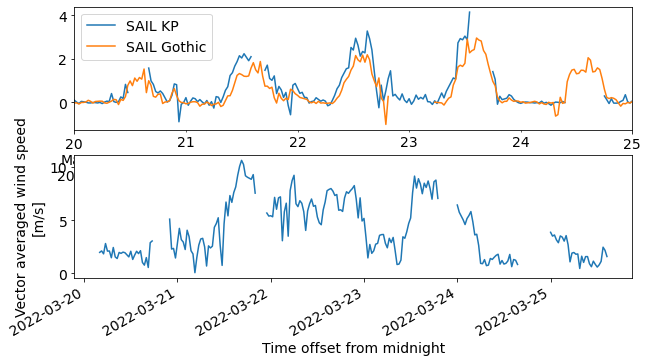

In [262]:
fig, axs=plt.subplots(2, figsize=(10,5))
sublimation_rate_ecor_kp_df[np.isin(sublimation_rate_ecor_kp_df.index.date, sub_date_idx.date)].loc[dt.date(2022,3,20):dt.date(2022,3,25)].plot(ax=axs[0],label='KP')
sublimation_rate_gts_df[np.isin(sublimation_rate_gts_df.index.date, sub_date_idx.date)].loc[dt.date(2022,3,20):dt.date(2022,3,25)].plot(ax=axs[0],label='Gothic')
ax.set_ylabel('Sublimation Rate (mm/day)')

ecor_kp_ds.sel(time=slice('2022-03-20','2022-03-25'))['wind_spd'].plot(ax=axs[1])
ax2.set_ylabel('Wind Speed (m/s)')

In [ ]:
# Create diurnal averages for all the data

diurnal_kp = sublimation_rate_kp.groupby('time.hour').mean()/24


diurnal_avery = sublimation_rate_ap.groupby('time.hour').mean()/24


diurnal_gts = sublimation_rate_gts.groupby('time.hour').mean()/24


diurnal_ecor_kp = sublimation_rate_ecor_kp.groupby('time.hour').mean()/24


diurnal_sublimation_bulk_gts = -Hl_bulk_gothic.groupby(Hl_bulk_gothic.index.hour).mean()/lv * 3600


diurnal_sublimation_bulk_kp = -Hl_bulk_kp.groupby(Hl_bulk_kp.index.hour).mean()/lv * 3600


diurnal_sublimation_pm = sublimation_pm_hourly.groupby(sublimation_pm_hourly.index.hour).mean()/24




### 2-D Heatmap Plots

Net Radiation and Wind Speed

In [337]:
import plotly.express as px
import plotly.graph_objects as go

In [364]:
df

,net_radiation,wspd_arith_mean,SAIL Gothic
local_time,,,
2021-12-31 17:00:00,-2.657745,4.243500,NaN
2021-12-31 17:30:00,-1.096863,3.243166,NaN
2021-12-31 18:00:00,-1.676514,2.517100,NaN
2021-12-31 18:30:00,-1.668060,4.666400,NaN
2021-12-31 19:00:00,-2.356232,3.436167,NaN
...,...,...,...
2022-04-30 15:30:00,206.136307,3.277766,2.016348
2022-04-30 16:00:00,173.496597,2.052067,1.802525
2022-04-30 16:30:00,132.612595,2.121833,1.660761


In [422]:
net_radiation = sebs_ds['net_radiation'].to_dataframe()
wind_speed = met_ds['wspd_arith_mean'].resample(time='30min').mean().to_dataframe()
gts_sublimation = sublimation_rate_gts.to_dataframe()

df = pd.concat([net_radiation,
                wind_speed,
                gts_sublimation], axis=1).set_index('local_time')
# Replace nans with -100
# df['SAIL Gothic'][df['SAIL Gothic'].isna()] = None


fig = px.density_heatmap(df, x="wspd_arith_mean", y="net_radiation", z="SAIL Gothic",histfunc="avg",
                         color_continuous_scale='RdBu_r',
                         title='10m Wind Speed and Net Radiation with SAIL ECOR sublimation rate<br>(January 1-April 30, 2022)',
                         labels={
                     "net_radiation": "Net Radiation (W/m^2)",
                     "wspd_arith_mean": "Wind Speed (m/s)",
                 },
                 width=800, height=600, range_color=[-4,4])

fig.update_layout(
    
fig.show()

In [448]:
fig = go.Figure()
fig.add_trace(go.Histogram2d(x=df['wspd_arith_mean'],y=df['net_radiation'],z=df['SAIL Gothic'],histfunc='avg',colorbar={"title": 'Sublimation Rate<br>mm/day'}, colorscale='RdBu_r', zmin=-4, zmax=4,))
fig.add_trace(go.Histogram2d(x=df['wspd_arith_mean'],y=df['net_radiation'],z=df['SAIL Gothic'],histfunc='count', colorscale='Greys_r',zmin=0,zmax=1,opacity=0.1, showscale=False))

fig.update_layout(
    title='10m Wind Speed and Net Radiation with SAIL ECOR sublimation rate<br>(January 1-April 30, 2022)',
    xaxis_title="Wind Speed (m/s)",
    yaxis_title="Net Radiation (W/m^2)",
    autosize=False,
    height=500,
    width=700,
)
fig.show()

Air temperature and number of hours of snowfall

In [285]:
wx_code = met_ds['pwd_pw_code_1hr'].resample(time='1H').mean()
daily_snowing_hours = (wx_code>66).resample(time='1D').sum()

In [321]:
temp = (ecor_gts_ds['mean_t'].resample(time='1D').mean()-273.15).to_dataframe()
gts_sublimation = sublimation_rate_gts.resample(time='1D').sum().to_dataframe()
snow_hours_df = daily_snowing_hours.to_dataframe()

df = pd.concat([snow_hours_df,
                temp,
                gts_sublimation], axis=1)

fig = px.density_heatmap(df, x="mean_t", y="pwd_pw_code_1hr", z="SAIL Gothic", nbinsx=20,nbinsy=30,
                         color_continuous_scale='Viridis',
                         title='Daily Mean 2m temperature and Daily Snowing Hours with SAIL ECOR<br>sublimation rate (January 1-April 30, 2022)',
                         labels={
                     "mean_t": "Daily Mean Temperature (C)",
                     "pwd_pw_code_1hr": "Daily Hours of Snowfall",
                 },
                 width=800, height=600)
fig.update_layout(
    coloraxis_colorbar=dict(
        title='Sublimation Rate<br>(mm/d)',
    ),
    yaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 2
    )
)
fig.show()

### Extra plots for each individual diurnal plot

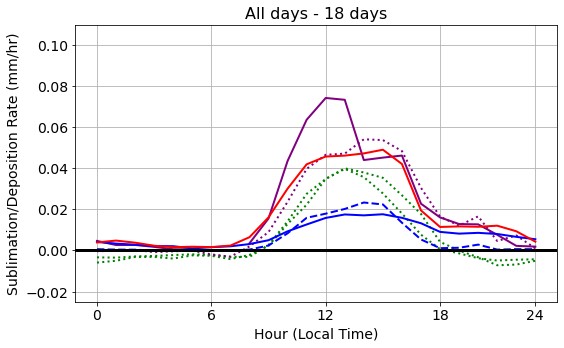

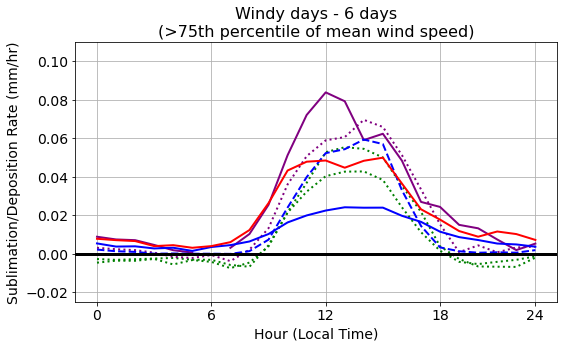

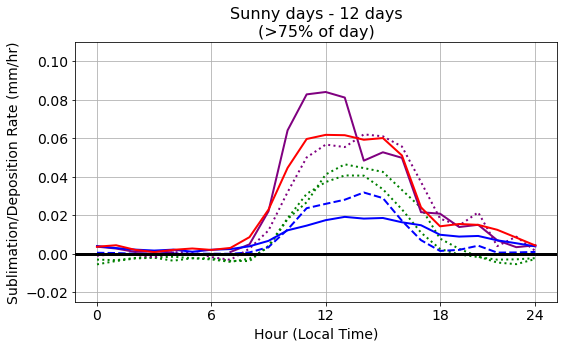

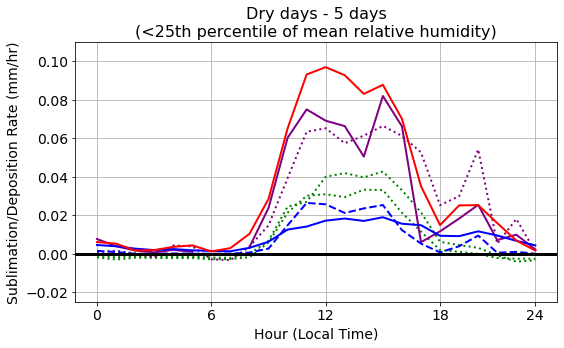

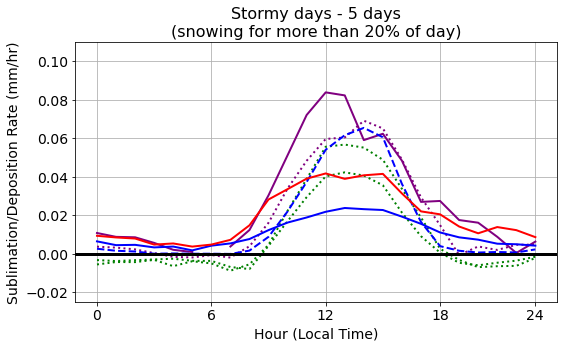

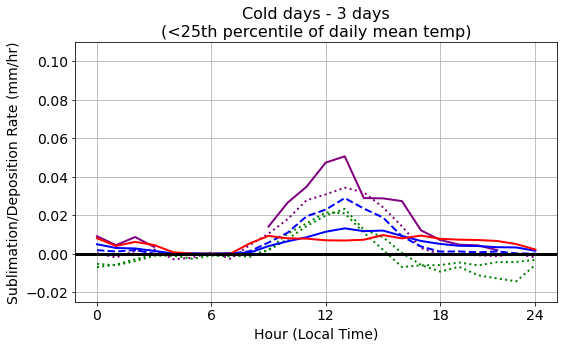

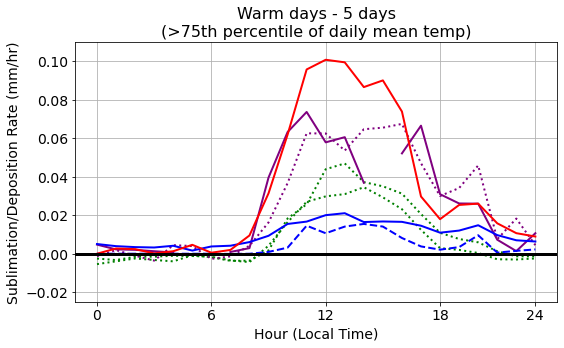

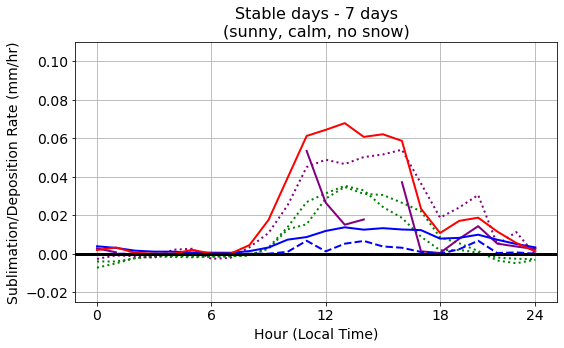

In [226]:


for i,cycle in enumerate(diurnal_cycles):
    fig, ax = plt.subplots(figsize=(8,5), sharex=True, tight_layout=True, facecolor='white')

    days = cycle.where(cycle == True, drop=True).time.dt.date.values

    ec_asfs_kp = sublimation_rate_kp_df[np.isin(sublimation_rate_kp_df.index.date, days)]
    (ec_asfs_kp.groupby(ec_asfs_kp.index.hour).mean()/24).plot(ax=ax, label='SPLASH KP', color='green', ls='dotted', lw=2, legend=False)

    ec_asfs_ap = sublimation_rate_ap_df[np.isin(sublimation_rate_ap_df.index.date, days)]
    (ec_asfs_ap.groupby(ec_asfs_ap.index.hour).mean()/24).plot(ax=ax, label='SPLASH AP', color='green', ls='dotted', lw=2, legend=False)

    ec_ecor_gts = sublimation_rate_gts_df[np.isin(sublimation_rate_gts_df.index.date, days)]
    (ec_ecor_gts.groupby(ec_ecor_gts.index.hour).mean()/24).plot(ax=ax, label='SAIL GTS', color='purple', ls='dotted', lw=2, legend=False)

    ec_ecor_kp = sublimation_rate_ecor_kp_df[np.isin(sublimation_rate_ecor_kp_df.index.date, days)]
    ec_ecor_kp_daily = (ec_ecor_kp.groupby(ec_ecor_kp.index.hour).mean()/24)
    ec_ecor_kp_daily[ec_ecor_kp_daily>0].plot(ax=ax, label='SAIL KP', color='purple', lw=2, legend=False)

    ba_gts = -Hl_bulk_gothic[np.isin(Hl_bulk_gothic.index.date, days)]
    (ba_gts.groupby(ba_gts.index.hour).mean()/lv * 3600).plot(ax=ax, label=f'SAIL BA Method', ls='dashed', lw=2, color='blue', legend=False)

    ba_kp = -Hl_bulk_kp[np.isin(Hl_bulk_kp.index.date, days)]
    (ba_kp.groupby(ba_kp.index.hour).mean()/lv * 3600).plot(ax=ax, label='SPLASH BA Method', lw=2, color='blue', legend=False)

    pm_gts = sublimation_pm_hourly[np.isin(sublimation_pm_hourly.index.date, days)]/24
    (pm_gts.groupby(pm_gts.index.hour).mean()).plot(ax=ax, label='SAIL Gothic Penman-Monteith ', color='red', lw=2, legend=False)

    ax.axhline(0,color='k', lw=3)
    ax.set_title(labels[i], fontsize=16)
    ax.set_ylabel('Sublimation/Deposition Rate (mm/hr)')
    ax.set_xlabel('Hour (Local Time)')
    ax.set_ylim(-0.025,0.11)
    ax.set_xticks([0,6,12,18,23])
    ax.set_xticklabels([0,6,12,18,24])
    ax.grid()
    fig.savefig(f'../../figures/diurnal_{i}.png')


# Additional Analyses
### TKE and wind speed turbulence regimes
### SAIL ECOR Gothic

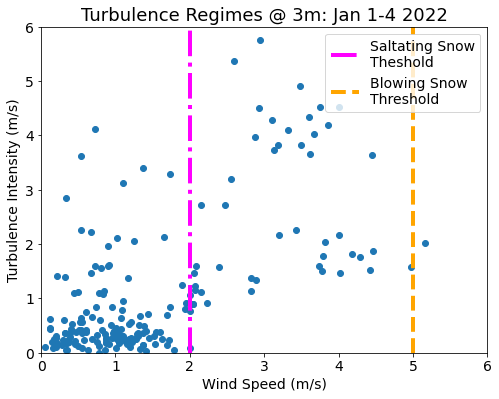

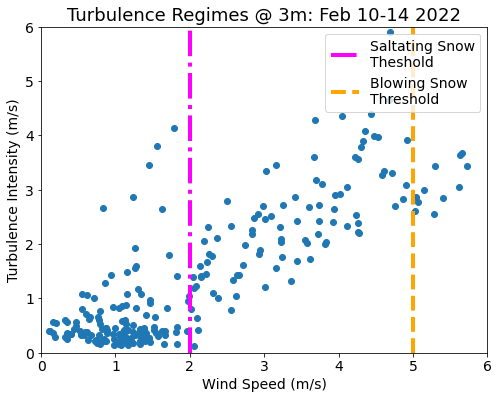

In [ ]:
# Create time slice
time_slice = slice('2022-01-01','2022-01-04')
# Subset the ECOR data
ecor_ds_subset = ecor_gts_ds.sel(time=time_slice)
# Compute TKE estimate
v_tke = (0.5 * (ecor_ds_subset['var_u']**2 + ecor_ds_subset['var_v']**2 + ecor_ds_subset['var_w']**2))**0.5
# Gather wind speed average
wind_speed = ecor_ds_subset.where(ecor_ds_subset['qc_wind_spd']==0)['wind_spd']

# Create plot
fig, ax = plt.subplots(figsize=(8,6))
fig.set_facecolor('white')
# Plote TKE and wind speed
ax.scatter(wind_speed, v_tke)
# Add saltating and blowing snow thresholds
ax.axvline(2,label='Saltating Snow\nTheshold', color='magenta', lw=4, ls='-.')
ax.axvline(5,label='Blowing Snow\nThreshold', color='orange', lw=4, ls='--')
# Plot formatting
ax.set_ylim(0,6)
ax.set_xlim(0,6)
ax.tick_params(axis='both', labelsize=14)
ax.set_xlabel('Wind Speed (m/s)',size=14)
ax.set_ylabel('Turbulence Intensity (m/s)', size=14)
ax.set_title('Turbulence Regimes @ 3m: Jan 1-4 2022', size=18)
ax.legend(loc='upper right',fontsize=14)

time_slice = slice('2022-02-10','2022-02-14')
# Subset the ECOR data
ecor_ds_subset = ecor_gts_ds.sel(time=time_slice)
# Compute TKE estimate
v_tke = (0.5 * (ecor_ds_subset['var_u']**2 + ecor_ds_subset['var_v']**2 + ecor_ds_subset['var_w']**2))**0.5
# Gather wind speed average
wind_speed = ecor_ds_subset.where(ecor_ds_subset['qc_wind_spd']==0)['wind_spd']

# Create plot
fig, ax = plt.subplots(figsize=(8,6))
fig.set_facecolor('white')
# Plote TKE and wind speed
ax.scatter(wind_speed, v_tke)
# Add saltating and blowing snow thresholds
ax.axvline(2,label='Saltating Snow\nTheshold', color='magenta', lw=4, ls='-.')
ax.axvline(5,label='Blowing Snow\nThreshold', color='orange', lw=4, ls='--')
# Plot formatting
ax.set_ylim(0,6)
ax.set_xlim(0,6)
ax.tick_params(axis='both', labelsize=14)
ax.set_xlabel('Wind Speed (m/s)',size=14)
ax.set_ylabel('Turbulence Intensity (m/s)', size=14)
ax.set_title('Turbulence Regimes @ 3m: Feb 10-14 2022', size=18)
ax.legend(loc='upper right',fontsize=14)

### SPLASH ASFS Kettle Ponds

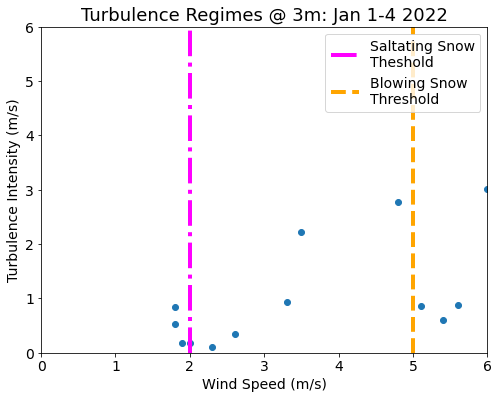

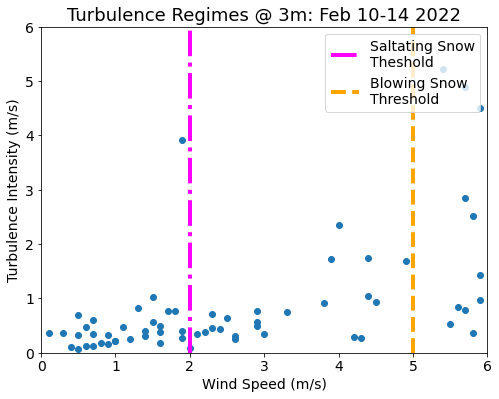

In [ ]:
# Plot as above for ASFS KP
time_slice = slice('2022-01-01','2022-01-04')
ecor_ds_subset = kp_asfs_ds.sel(time=time_slice)
v_tke = (0.5 * (ecor_ds_subset['sigU']**4 + ecor_ds_subset['sigV']**4 + ecor_ds_subset['sigW']**4))**0.5
wind_speed = radsys_ds.sel(time=v_tke.time).where(radsys_ds.WindSpd_qc==0)['WindSpd']

fig, ax = plt.subplots(figsize=(8,6))
fig.set_facecolor('white')

ax.scatter(wind_speed, v_tke)

ax.axvline(2,label='Saltating Snow\nTheshold', color='magenta', lw=4, ls='-.')
ax.axvline(5,label='Blowing Snow\nThreshold', color='orange', lw=4, ls='--')

ax.set_ylim(0,6)
ax.set_xlim(0,6)
ax.tick_params(axis='both', labelsize=14)
ax.set_xlabel('Wind Speed (m/s)',size=14)
ax.set_ylabel('Turbulence Intensity (m/s)', size=14)
ax.set_title('Turbulence Regimes @ 3m: Jan 1-4 2022', size=18)
ax.legend(loc='upper right',fontsize=14)

time_slice = slice('2022-02-10','2022-02-14')
ecor_ds_subset = kp_asfs_ds.sel(time=time_slice)
v_tke = (0.5 * (ecor_ds_subset['sigU']**4 + ecor_ds_subset['sigV']**4 + ecor_ds_subset['sigW']**4))**0.5
wind_speed = radsys_ds.sel(time=v_tke.time).where(radsys_ds.WindSpd_qc==0)['WindSpd']

fig, ax = plt.subplots(figsize=(8,6))
fig.set_facecolor('white')

ax.scatter(wind_speed, v_tke)

ax.axvline(2,label='Saltating Snow\nTheshold', color='magenta', lw=4, ls='-.')
ax.axvline(5,label='Blowing Snow\nThreshold', color='orange', lw=4, ls='--')

ax.set_ylim(0,6)
ax.set_xlim(0,6)
ax.tick_params(axis='both', labelsize=14)
ax.set_xlabel('Wind Speed (m/s)',size=14)
ax.set_ylabel('Turbulence Intensity (m/s)', size=14)
ax.set_title('Turbulence Regimes @ 3m: Feb 10-14 2022', size=18)
ax.legend(loc='upper right',fontsize=14)

### SPLASH ASFS Avery Picnic

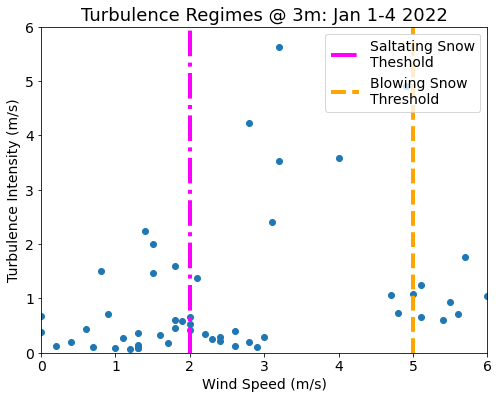

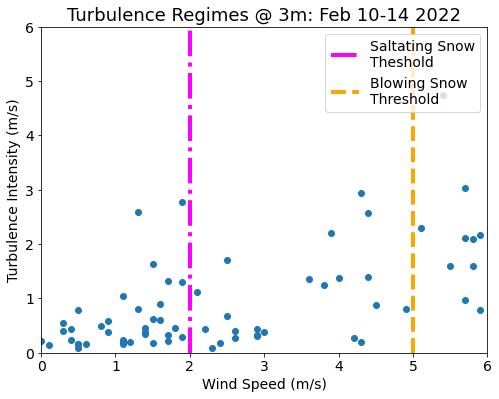

In [ ]:
# plot as above for ASFS AP
time_slice = slice('2022-01-01','2022-01-04')
ecor_ds_subset = ap_asfs_ds.sel(time=time_slice)
v_tke = (0.5 * (ecor_ds_subset['sigU']**4 + ecor_ds_subset['sigV']**4 + ecor_ds_subset['sigW']**4))**0.5
wind_speed = radsys_ds.sel(time=v_tke.time).where(radsys_ds.WindSpd_qc==0)['WindSpd']

fig, ax = plt.subplots(figsize=(8,6))
fig.set_facecolor('white')

ax.scatter(wind_speed, v_tke)

ax.axvline(2,label='Saltating Snow\nTheshold', color='magenta', lw=4, ls='-.')
ax.axvline(5,label='Blowing Snow\nThreshold', color='orange', lw=4, ls='--')

ax.set_ylim(0,6)
ax.set_xlim(0,6)
ax.tick_params(axis='both', labelsize=14)
ax.set_xlabel('Wind Speed (m/s)',size=14)
ax.set_ylabel('Turbulence Intensity (m/s)', size=14)
ax.set_title('Turbulence Regimes @ 3m: Jan 1-4 2022', size=18)
ax.legend(loc='upper right',fontsize=14)

time_slice = slice('2022-02-10','2022-02-14')
ecor_ds_subset = ap_asfs_ds.sel(time=time_slice)
v_tke = (0.5 * (ecor_ds_subset['sigU']**4 + ecor_ds_subset['sigV']**4 + ecor_ds_subset['sigW']**4))**0.5
wind_speed = radsys_ds.sel(time=v_tke.time).where(radsys_ds.WindSpd_qc==0)['WindSpd']

fig, ax = plt.subplots(figsize=(8,6))
fig.set_facecolor('white')

ax.scatter(wind_speed, v_tke)

ax.axvline(2,label='Saltating Snow\nTheshold', color='magenta', lw=4, ls='-.')
ax.axvline(5,label='Blowing Snow\nThreshold', color='orange', lw=4, ls='--')

ax.set_ylim(0,6)
ax.set_xlim(0,6)
ax.tick_params(axis='both', labelsize=14)
ax.set_xlabel('Wind Speed (m/s)',size=14)
ax.set_ylabel('Turbulence Intensity (m/s)', size=14)
ax.set_title('Turbulence Regimes @ 3m: Feb 10-14 2022', size=18)
ax.legend(loc='upper right',fontsize=14)

### Functions to produce Penman-Monteith Estimates to compare to PYET

In [ ]:
def calc_penman_monteith(Rn, G, rh, Ta, wspd):
    Cp = 1005 # J/Kg-K
    GAMMA = 0.4 # psychrometric constant
    rho = 28.97 * 70/(8.314*(Ta+273.15))
    Ta_C = Ta.to_xarray().squeeze()
    Ta_C.attrs = {'units':'celsius'}
    
    es = calc.saturation_vapor_pressure(Ta_C).values # temperature in Celsius
    e = rh/100 * es
    delta = (21.87 * 265.5 * es) / (265.5 + Ta)**2
    ra = calc_aerodynamic_resistance(Ta, wspd, rh)

    latent_heat =(delta * (Rn - G) + (rho * Cp * (es - e)/ra)) / (delta + GAMMA)
    return latent_heat/2.834e6 * 3600 * 24

def calc_aerodynamic_resistance(Ta, wspd, rh):
    Z = 10
    Z0 = 0.0002
    K = 0.4
    # Convert temperature to Kelvin
    Ta_K = Ta.to_xarray().squeeze()+273.15
    Ta_K.attrs = {'units':'K'}

    Ts = calc.dewpoint_from_relative_humidity(Ta_K,(rh/100).to_xarray()).values + 273.15
    phi = calc_stability_correction(calc_richardson_numbers(Ta_K, Ts, wspd))

    ra = (np.log(Z/Z0))**2 / (K**2 * wspd * phi)
    return ra

def calc_stability_correction(Ri_nums):
    phi = np.zeros_like(Ri_nums)
    
    for i,Ri in enumerate(Ri_nums):
        if Ri >= 0:
            phi[i] = (1-5*Ri)**2
        elif Ri < 0:
            phi[i] = (1-16*Ri)**0.75            
    return phi

def calc_richardson_numbers(Ta, Ts, wspd):
    g = 9.81 # gravity constant
    Z = 10 # measurement height
    Tmean = (Ta + Ts)/2

    Ri = (g * Z * (Ta-Ts)) / (Tmean * wspd**2)
    
    return Ri

### Comparison between personal functions and pyet

In [ ]:
sublimation_pm_2 = calc_penman_monteith(rn,0,rh_mean,temp_mean,wind_mean)
sublimation_daily = sublimation_pm_2.mask(sublimation_pm_2  > 2).interpolate()


<AxesSubplot:xlabel='time'>

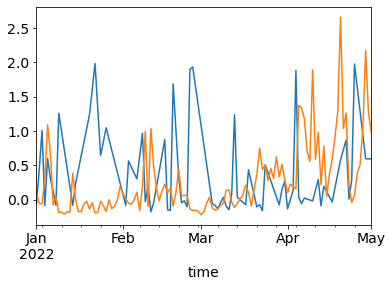

In [ ]:
sublimation_daily.plot()
(sublimation_pm/2).plot()

### Sensitivity of Penman to estimates of solar radiation using just longwave and function from Marks & Dozier

In [ ]:
def calc_net_lw_radiation(temperature, relative_humidity, pressure, elevation, dew_pt_temp=None, cst=40):
    SIGMA = 5.67e-8
    CONSTANT = cst

    # Convert temperature to Kelvin
    temperature_K = temperature.to_xarray().squeeze()+273.15
    temperature_K.attrs = {'units':'K'}


    # Using Marks & Dozier, 1979 to calculate emissivity 
    T_prime = temperature_K + (0.0065 * elevation/3.28)
    T_prime.attrs = {'units':'K'}
    e_prime = relative_humidity*calc.saturation_vapor_pressure(T_prime)/100
    
    # Emissivity estimate
    epsilon_atmos=(1.24 * (e_prime/T_prime)**(1/7) * (69277.74)/101300)

    # Longwave in estimate
    lw_in = epsilon_atmos * SIGMA * temperature_K**4 - CONSTANT

    # Calculate longwave out
    if dew_pt_temp is None:
        dew_pt_temp = calc.dewpoint_from_relative_humidity(temperature_K,(relative_humidity/100).to_xarray()).values
    lw_out = SIGMA*(dew_pt_temp+273.15)**4

    # Compute net longwave radiation
    rnet = lw_in - lw_out
    return rnet

In [ ]:
sebs_df = sebs_ds.down_long.resample(time='1D').mean().to_pandas()
radsys_df = radsys_ds.where(radsys_ds.dw_ir_qc==0).dw_ir.resample(time='1D').mean().to_pandas()
lw_out = calc_net_lw_radiation(temp_mean,rh_mean, press_mean,elev)

df = pd.concat({'sebs':sebs_df, 'radsys':radsys_df, 'model':lw_out}, axis=1)

stats.levene(df['radsys'],df['model'], center='mean')




LeveneResult(statistic=80.48184552442007, pvalue=8.613398336040638e-17)

In [ ]:
mock_rn = calc_net_lw_radiation(temp_mean,rh_mean,press_mean, elev)*3600*24/1e6 

In [ ]:
df = pd.concat({'rn':rn.loc[:dt.date(2022,4,1)], 'mock_rn':mock_rn.loc[:dt.date(2022,4,1)]}, axis=1)
df.describe()

,rn,mock_rn
count,91.000000,91.000000
mean,-4.549380,-3.966196
std,1.298873,1.162870
min,-6.757698,-6.359113
25%,-5.533146,-4.806314
50%,-4.899473,-4.031110
75%,-3.509249,-3.297047
max,-0.904033,-0.692876


In [ ]:
# sublimation sensitivity
sublimation_pm_mock_rn = pyet.pm(tmean=temp_mean,
                                    wind=wind_mean,
                                    rh=rh_mean,
                                    rn=mock_rn,
                                    elevation=elev)
                                                  


In [ ]:
sublimation_pm_mock_rn.loc[:dt.date(2022,4,1)].sum()

8.19621337232527

In [ ]:
sublimation_pm.loc[:dt.date(2022,4,1)].sum()

7.919109392635516

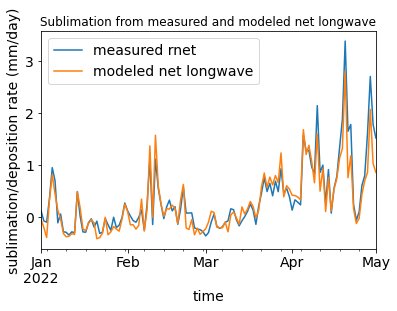

In [ ]:
fig,ax=plt.subplots()
sublimation_pm.plot(ax=ax, label='measured rnet')
sublimation_pm_mock_rn.plot(ax=ax, label='modeled net longwave')
ax.set_title('Sublimation from measured and modeled net longwave')
ax.set_ylabel('sublimation/deposition rate (mm/day)')
ax.legend()

In [ ]:
r_value = stats.linregress(sublimation_pm_mock_rn,sublimation_pm)[2]

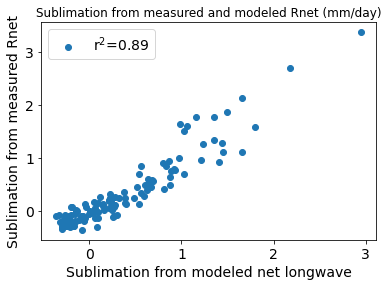

In [ ]:
fig,ax=plt.subplots()
ax.scatter(sublimation_pm_mock_rn,sublimation_pm, label=f'r$^2$={round(r_value**2,2)}')
ax.set_title('Sublimation from measured and modeled Rnet (mm/day)')
ax.set_ylabel('Sublimation from measured Rnet')
ax.set_xlabel('Sublimation from modeled net longwave')
ax.legend()

### Estimate of sublimation using Snodgrass data from Mark Raleigh

In [ ]:
lat    =    38.926571550
lon    =   -106.978929234
cols = ['year',
        'month',
        'day',
        'hour (MST)',
        'minute',
        'air temperature (deg C)',
        'relative humidity (%)',
        'avg. wind speed (m/s)',
        'max. wind speed (m/s)',
        'incoming shortwave radiation (W/m2)',
        'reflected shortwave radiation (W/m2)',
        'incoming longwave radiation (W/m2)',
        'skin surface temperature (deg C)',
        'snow depth (cm) or ground veg height (cm)',
        'accum precip (mm) -- open site only']

sublimation_pm_hr = pd.read_csv('./data/SND_opn_AWS_data_001day.csv', names=cols)
sublimation_pm_hr['datetimes'] = pd.to_datetime(sublimation_pm_hr['year'].astype(str) + '-' + sublimation_pm_hr['month'].astype(str) + '-' + sublimation_pm_hr['day'].astype(str), format='%Y-%m-%d')
sublimation_daily_max = sublimation_pm_hr.groupby(sublimation_pm_hr['datetimes']).max()
sublimation_daily_min = sublimation_pm_hr.groupby(sublimation_pm_hr['datetimes']).min()

sublimation_pm_daily = pd.read_csv('./data/SND_opn_AWS_data_001day.csv', names=cols)
sublimation_pm_daily_subset = sublimation_pm_daily[(sublimation_pm_daily['year']==2022) & (sublimation_pm_daily['month']<4)]
sublimation_pm_daily_subset['datetimes'] = pd.to_datetime(sublimation_pm_daily_subset['year'].astype(str) + '-' + sublimation_pm_daily_subset['month'].astype(str) + '-' + sublimation_pm_daily_subset['day'].astype(str), format='%Y-%m-%d')

sublimation_pm_daily_subset = sublimation_pm_daily_subset.set_index('datetimes', drop=True)
sublimation_pm_daily_subset['max_temp'] =sublimation_daily_max.loc[sublimation_pm_daily_subset.index,'air temperature (deg C)']
sublimation_pm_daily_subset['min_temp'] =sublimation_daily_min.loc[sublimation_pm_daily_subset.index,'air temperature (deg C)']
sublimation_pm_daily_subset['max_rh'] =sublimation_daily_max.loc[sublimation_pm_daily_subset.index,'relative humidity (%)']
sublimation_pm_daily_subset['min_rh'] =sublimation_daily_min.loc[sublimation_pm_daily_subset.index,'relative humidity (%)']

In [ ]:
net_rad = (sublimation_pm_daily_subset['incoming shortwave radiation (W/m2)'] - sublimation_pm_daily_subset['reflected shortwave radiation (W/m2)'])+ (sublimation_pm_daily_subset['incoming longwave radiation (W/m2)'] - 5.67e-8*(273.15+sublimation_pm_daily_subset['skin surface temperature (deg C)'])**4)



In [ ]:
sublimation_snodgrass = pyet.pm(tmean=sublimation_pm_daily_subset['air temperature (deg C)'],
        tmax=sublimation_pm_daily_subset['max_temp'],
        tmin=sublimation_pm_daily_subset['min_temp'],
        rhmax=sublimation_pm_daily_subset['max_rh'],
        rhmin=sublimation_pm_daily_subset['min_rh'],
        wind=sublimation_pm_daily_subset['avg. wind speed (m/s)'],
        rh=sublimation_pm_daily_subset['relative humidity (%)'],
        lat=lat,
        rs=sublimation_pm_daily_subset['incoming shortwave radiation (W/m2)']*3600*24/1e6,
        rn=net_rad*3600*24/1e6,
        elevation=3132.24)